# **Retrieval Augmented Generation: A Practical Dive**

## Section 1: Retrieval
---

### 1.0 Install Necessary Libraries

In [58]:
!pip install transformers torch faiss-cpu matplotlib scikit-learn mplcursors

## Classes

In [29]:
import torch
import numpy as np
import faiss
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

## Documents

In [30]:
def extracted_text(raw_text):
    docs = raw_text.split('\n')
    return docs

In [31]:
raw_text = """Retrieval-Augmented Generation (RAG) is a powerful technique that enhances the capabilities of language models by integrating a retrieval mechanism with generative AI.\n
Instead of relying solely on pre-trained knowledge, RAG actively retrieves relevant documents from an external knowledge base before generating responses.\n
This allows the model to produce more factual, context-aware, and up-to-date answers.\n
A key component of RAG is the Dense Passage Retriever (DPR), which efficiently searches for relevant documents by encoding both questions and passages into a shared vector space.\n
Unlike traditional keyword-based retrieval systems, DPR uses a dual-encoder model trained to maximize similarity between queries and relevant passages.\n
The context encoder transforms textual data into dense embeddings, while the question encoder generates vector representations of user queries.\n
These embeddings are then indexed using FAISS (Facebook AI Similarity Search), allowing for fast and efficient nearest-neighbor searches.\n
When a user inputs a question, the DPR question encoder generates an embedding, which is then matched against a precomputed FAISS index of document embeddings.\n
The top-ranked passages are retrieved based on similarity scores and provided as context to the generative model, such as GPT-2 or GPT-3, which synthesizes a response.\n
This hybrid approach significantly improves the accuracy of open-domain question-answering systems by grounding responses in retrieved evidence.\n
The applications of RAG extend beyond Q&A systems to areas such as legal document analysis, scientific research summarization, and customer support automation.\n
By leveraging an external corpus and dynamically retrieving information, RAG reduces hallucination and enhances trustworthiness in AI-generated content.\n
Researchers continue to refine retrieval techniques, incorporating advancements such as hierarchical retrieval, multi-hop reasoning, and hybrid search strategies that blend dense and sparse retrieval methods for improved performance."""


In [32]:
# Sample paragraphs of text for RAG
docs = extracted_text(raw_text)

In [44]:
print(docs[0])

Retrieval-Augmented Generation (RAG) is a powerful technique that enhances the capabilities of language models by integrating a retrieval mechanism with generative AI.


## Embeddings

In [45]:
# Tokenizer and Encoder
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.
Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod

In [47]:
tokens=context_tokenizer(docs, return_tensors='pt', padding=True, truncation=True, max_length=256)
outputs=context_encoder(**tokens)
print(outputs.pooler_output)

tensor([[-0.3301, -0.5804,  0.3514,  ..., -0.7320, -0.5986, -0.0413],
        [-0.6405, -0.4024, -0.4379,  ..., -0.2095,  0.1768,  0.1428],
        [ 0.0970, -0.3857,  0.1642,  ..., -0.4647, -0.0638,  0.1101],
        ...,
        [-0.1082, -0.1439,  0.4453,  ..., -0.5528, -0.3393, -0.0765],
        [-0.6405, -0.4024, -0.4379,  ..., -0.2095,  0.1768,  0.1428],
        [ 0.0512,  0.1610, -0.0381,  ..., -0.4961, -0.0023, -0.1184]],
       grad_fn=<SliceBackward0>)


In [53]:
print(outputs.pooler_output.detach().numpy().shape)


(25, 768)


In [55]:
# Now we will try to decompose high dimensional embeddings 
# from 384 to 2 so that we can plot it and visualize
from sklearn.decomposition import PCA

embedding = outputs.pooler_output.detach().numpy()
# Perform PCA for 2D visualization
PCA_model = PCA(n_components = 2)
PCA_model.fit(embedding)
new_embeddings = PCA_model.transform(embedding)

In [56]:
new_embeddings.shape

(25, 2)

In [67]:
import matplotlib.pyplot as plt
import mplcursors

def plot2d(x_values, y_values, text_labels):
    """
    Create a 2D plot with annotations.

    Parameters:
    - x_values (array): X-axis values.
    - y_values (array): Y-axis values.
    - text_labels (list): List of text labels for each point.
    """
    fig, ax = plt.subplots()
    scatter = ax.scatter(x_values, y_values, label='Data Points')

    # Annotate points with text labels
    for i, label in enumerate(text_labels):
        ax.annotate(label, (x_values[i], y_values[i]))

    mplcursors.cursor(hover=True)

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('2D Plot with Annotations')
    plt.figure(figsize=(20,20))

    plt.show()

In [64]:
def tsne_plot(data):
    # Apply t-SNE to reduce high dimensions to 3D
    tsne = TSNE(n_components=3, random_state=42, perplexity=min(data.shape[0]-1, 30))  # Perplexity capped for valid range
    data_3d = tsne.fit_transform(data)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Assign colors for each point based on its index
    num_points = len(data_3d)
    colors = plt.cm.tab20(np.linspace(0, 1, num_points))

    # Plot scatter with unique colors for each point
    for idx, point in enumerate(data_3d):
        ax.scatter(point[0], point[1], point[2], label=str(idx), c=[colors[idx]])  # Use c=[...] for proper color passing

    # Adding labels and titles
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization')
    plt.legend(title='Input Order')
    plt.show()

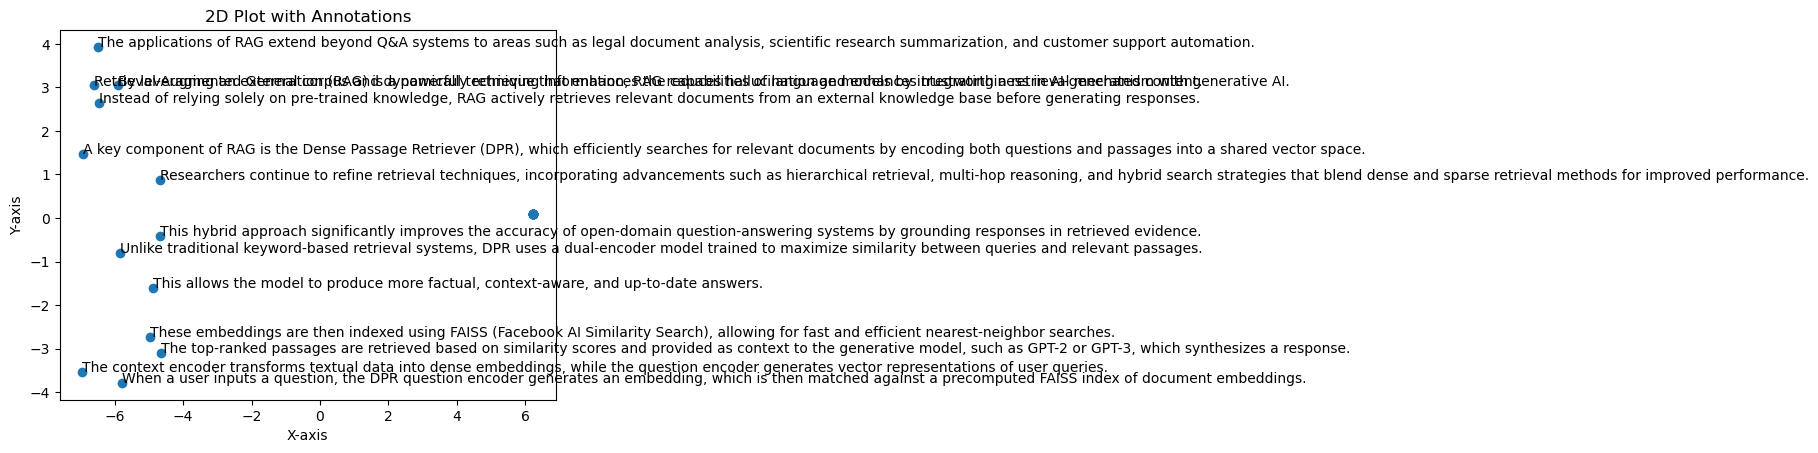

<Figure size 2000x2000 with 0 Axes>

In [68]:
# pass the embeddings and original sentence to create labels
plot2d(new_embeddings[:,0], new_embeddings[:,1], docs)

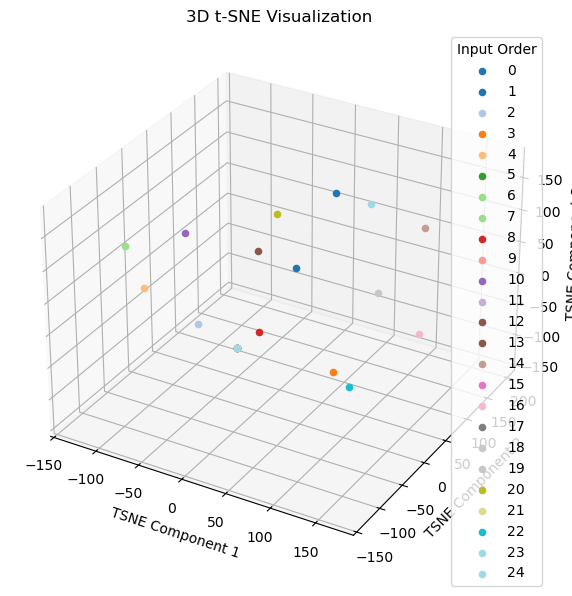

In [69]:
tsne_plot(outputs.pooler_output.detach().numpy())

In [15]:
# Create FAISS index
embedding_dim = context_embeddings.shape[1]
context_embeddings_np = np.array(context_embeddings).astype('float32')
index = faiss.IndexFlatL2(embedding_dim)
index.add(context_embeddings_np)

In [16]:
# Load DPR question encoder and tokenizer
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [17]:
def search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5):
    question_inputs = question_tokenizer(question, return_tensors='pt')
    question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()
    D, I = index.search(question_embedding, k)
    return D, I

In [18]:
# Load GPT-2 Model
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
model.generation_config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [19]:
def generate_answer(question, contexts):
    input_text = question + ' ' + ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_new_tokens=50, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True, pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [20]:
# Example Question
question = "What film won Best Picture?"
_, I = search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)

In [21]:
top_contexts = [sample_texts[idx] for idx in I[0]]
print(f"Top Contexts: {top_contexts}")
print("Generated Answer:", generate_answer(question, top_contexts))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Top Contexts: ['The 2022 Academy Awards saw an incredible lineup of films competing for Best Picture, with the winner being a critically acclaimed drama.', "Space exploration has reached new heights with NASA's recent missions to Mars, aiming to uncover the planet's potential for past life.", 'Autonomous vehicles are progressing towards mainstream adoption, with safety and efficiency improvements.', 'Renewable energy sources such as solar and wind power are becoming increasingly viable alternatives to fossil fuels.', 'Advances in biomedical engineering have led to breakthroughs in prosthetics and medical imaging.']
Generated Answer: What film won Best Picture? The 2022 Academy Awards saw an incredible lineup of films competing for Best Picture, with the winner being a critically acclaimed drama. Space exploration has reached new heights with NASA's recent missions to Mars, aiming to uncover the planet's potential for past life. Autonomous vehicles are progressing towards mainstream ado